In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pyarrow.parquet as pq
import gc
import pywt
from statsmodels.robust import mad
import scipy
from scipy import signal
from scipy.signal import butter

import warnings

# Suppress pandas future warnings, I am using different library versions locally
# that do not raise warnings.
warnings.simplefilter(action='ignore', category=FutureWarning)

data_dir = '../input'

In [2]:
print(scipy.__version__)

1.1.0


In [3]:
metadata_train = pd.read_csv(data_dir + '/metadata_train.csv')
metadata_train.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [4]:
subset_train = pq.read_pandas(data_dir + '/train.parquet', columns=[str(i) for i in range(3)]).to_pandas()

In [5]:
subset_train.memory_usage(index=True).sum()

2400080

In [6]:
# 800,000 data points taken over 20 ms
# Grid operates at 50hz, 0.02 * 50 = 1, so 800k samples in 20 milliseconds will capture one complete cycle
n_samples = 800000

# Sample duration is 20 miliseconds
sample_duration = 0.02

# Sample rate is the number of samples in one second
# Sample rate will be 40mhz
sample_rate = n_samples * (1 / sample_duration)

def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def high_pass_filter(x, low_cutoff=1000, sample_rate=sample_rate):
    """
    From @randxie https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
    Modified to work with scipy version 1.1.0 which does not have the fs parameter
    """
    
    # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * sample_rate
    norm_low_cutoff = low_cutoff / nyquist
    
    # Fault pattern usually exists in high frequency band. According to literature, the pattern is visible above 10^4 Hz.
    # scipy version 1.2.0
    #sos = butter(10, low_freq, btype='hp', fs=sample_fs, output='sos')
    
    # scipy version 1.1.0
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, x)

    return filtered_sig

def denoise_signal( x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest( coeff[-level] )

    # Calculte the univeral threshold
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff, wavelet, mode='per' )

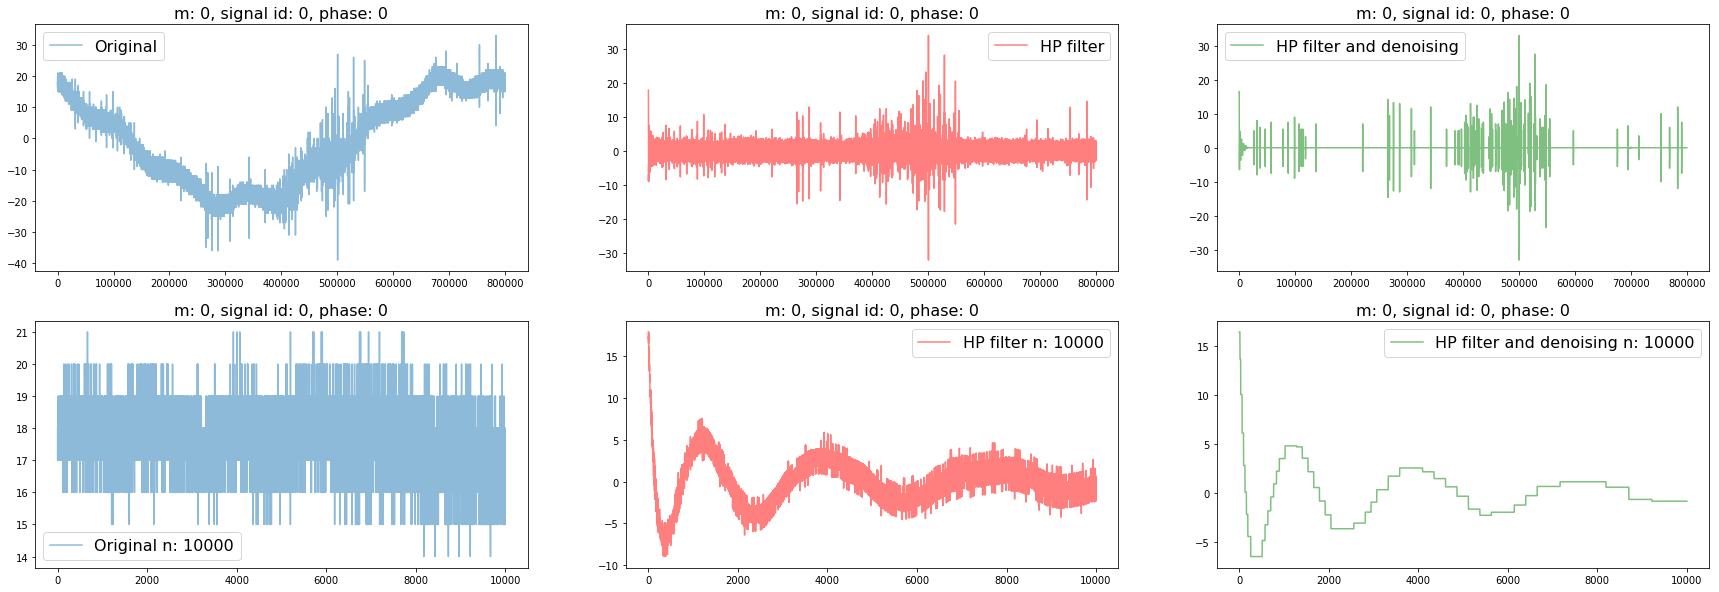

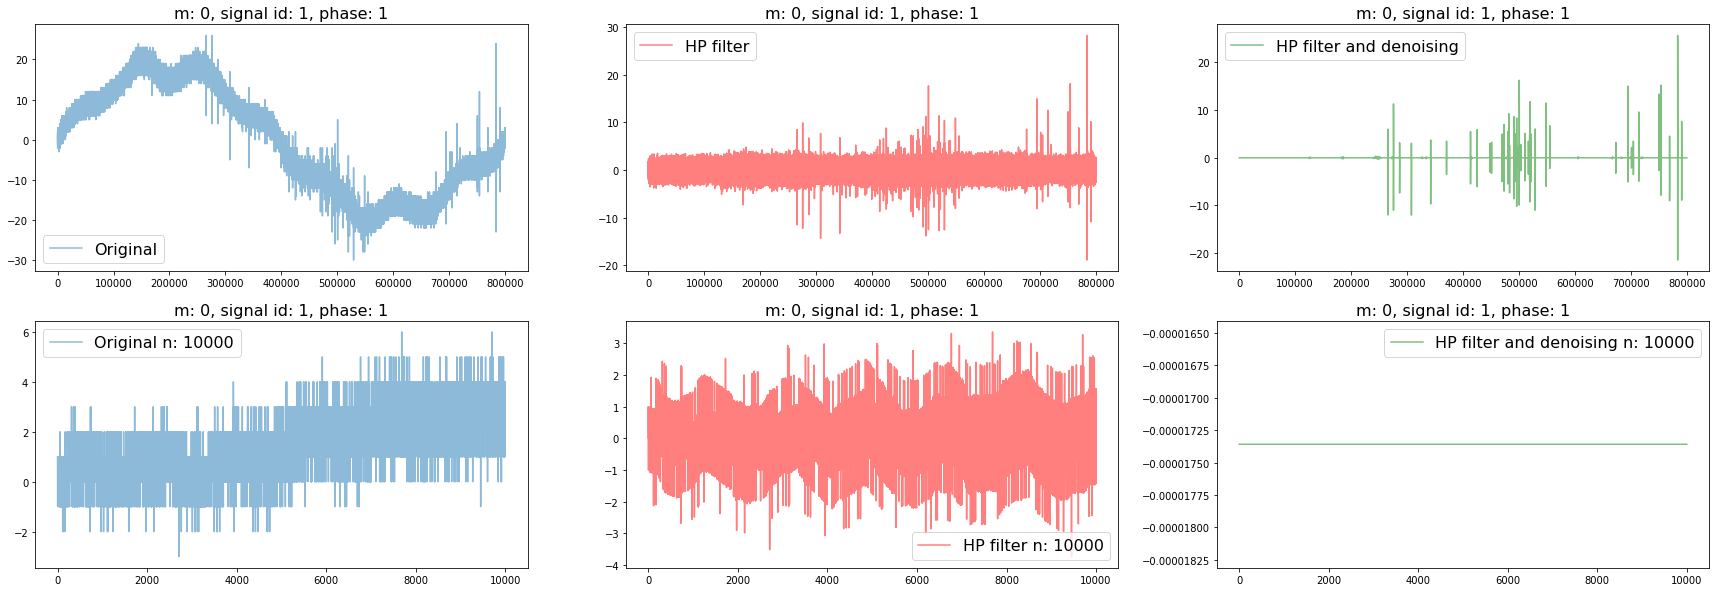

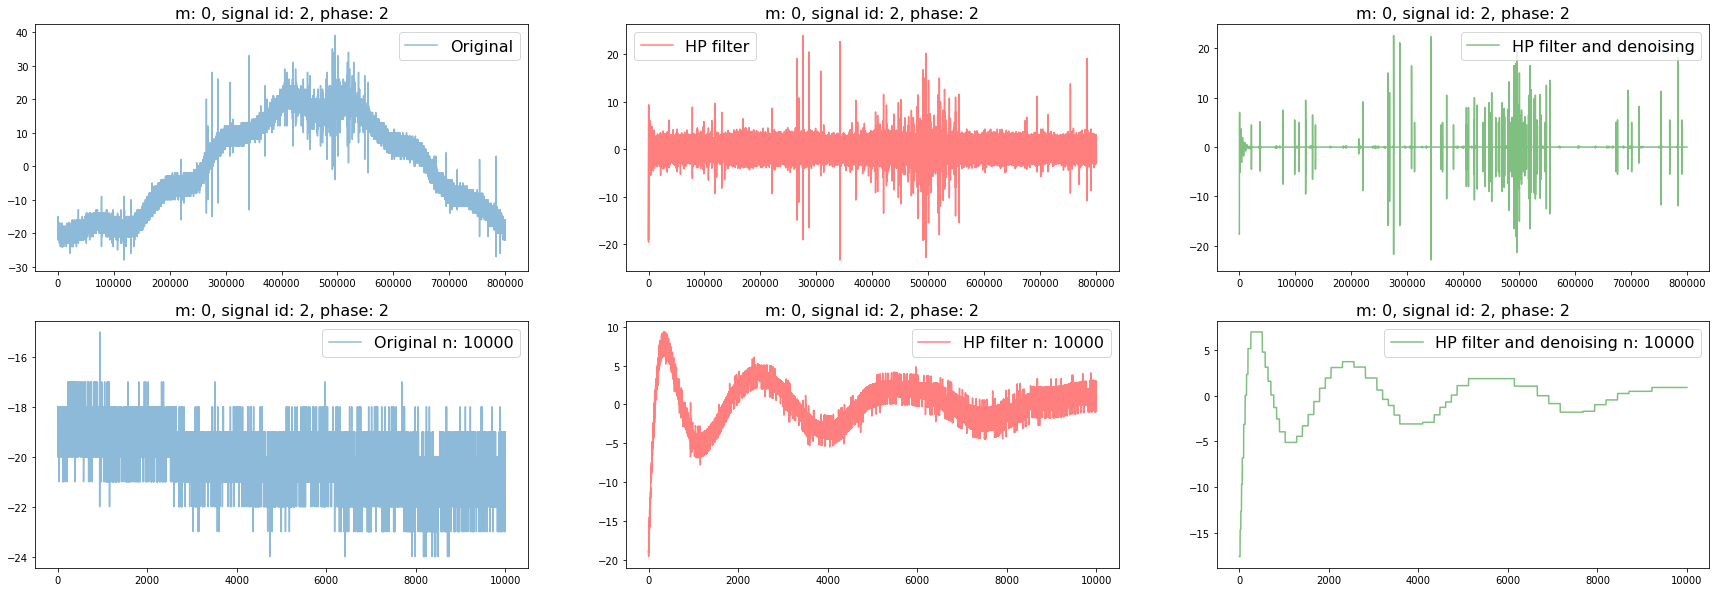

In [7]:
train_length = 3
for i in range(train_length):
    signal_id = str(i)
    meta_row = metadata_train[metadata_train['signal_id'] == i]
    measurement = str(meta_row['id_measurement'].values[0])
    signal_id = str(meta_row['signal_id'].values[0])
    phase = str(meta_row['phase'].values[0])
    
    subset_train_row = subset_train[signal_id]
    
    # Apply high pass filter with low cutoff of 10kHz, this will remove the low frequency 50Hz sinusoidal motion in the signal
    x_hp = high_pass_filter(subset_train_row, low_cutoff=10000, sample_rate=sample_rate)
    
    # Apply denoising
    x_dn = denoise_signal(x_hp, wavelet='haar', level=1)
    
    slice_size = 10000
    font_size = 16
    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))
    
    ax[0, 0].plot(subset_train_row, alpha=0.5)
    ax[0, 0].set_title(f"m: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[0, 0].legend(['Original'], fontsize=font_size)
    
    # Show smaller slice of the signal to get a better idea of the effect the high pass frequency filter is having on the signal
    ax[1, 0].plot(subset_train_row[:slice_size], alpha=0.5)
    ax[1, 0].set_title(f"m: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[1, 0].legend([f"Original n: {slice_size}"], fontsize=font_size)
    
    ax[0, 1].plot(x_hp, 'r', alpha=0.5)
    ax[0, 1].set_title(f"m: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[0, 1].legend(['HP filter'], fontsize=font_size)
    ax[1, 1].plot(x_hp[:slice_size], 'r', alpha=0.5)
    ax[1, 1].set_title(f"m: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[1, 1].legend([f"HP filter n: {slice_size}"], fontsize=font_size)
    
    ax[0, 2].plot(x_dn, 'g', alpha=0.5)
    ax[0, 2].set_title(f"m: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[0, 2].legend(['HP filter and denoising'], fontsize=font_size)
    ax[1, 2].plot(x_dn[:slice_size], 'g', alpha=0.5)
    ax[1, 2].set_title(f"m: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[1, 2].legend([f"HP filter and denoising n: {slice_size}"], fontsize=font_size)
    
    plt.show()